# Importing The Dataset


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00


Importing the daily dialog dataset

In [3]:
from datasets import load_dataset
dataset = load_dataset('daily_dialog')

Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 11118
    })
    validation: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
})

Combing all text and saving to a txt file.

In [5]:
# Combining Text
def conv_to_list_function(examples):
    return ["".join(x) for x in examples]

#cleaning first 1000 dialogs
text_list = conv_to_list_function(dataset['train'][:1000]['dialog'])

In [6]:
len(text_list)

1000

In [7]:
text = ''
for x in text_list:
  text += x
print('Length of the full text: ', len(text))
print('Printing first 150 characters of the string: \n', text[:150])

Length of the full text:  457651
Printing first 150 characters of the string: 
 Say , Jim , how about going for a few beers after dinner ?  You know that is tempting but is really not good for our fitness .  What do you mean ? It 


In [8]:
# Saving the input text to a file

with open('input.txt', 'w') as file:
  file.write(text)

# Tokenizing and Model Training

In [9]:
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, TFAutoModelForCausalLM
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

1. AutoTokenizer: used to load a pretrained tokenizer, to tokenize text into numbers
2. DataCollatorForLanguageModeling: used to generate labels from the input given
3. TFAutoModelForCausalLM: used to load model to fine tune it to data

In [10]:
tokenizer = AutoTokenizer.from_pretrained('distilgpt2')

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Tokenizing Data

In [11]:
def preprocess_function(examples):
    return tokenizer([" ".join(x) for x in examples["dialog"]])

In [12]:
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns = dataset["train"].column_names,
)

Map (num_proc=4):   0%|          | 0/11118 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 11118
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1000
    })
})

Creating batches along with a label feature

In [14]:
block_size = 128

def group_texts(examples):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [15]:
lm_dataset = tokenized_dataset.map(group_texts, batched=True, num_proc=4)
lm_dataset

Map (num_proc=4):   0%|          | 0/11118 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 11139
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1022
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 999
    })
})

In [16]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False, return_tensors="tf")

In [17]:
from transformers import TFAutoModelForCausalLM
model = TFAutoModelForCausalLM.from_pretrained("distilgpt2")

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [18]:
tokenizer.pad_token = tokenizer.eos_token

tf_train_set = model.prepare_tf_dataset(
    lm_dataset["train"],
    shuffle = True,
    batch_size = 32,
    collate_fn = data_collator,
)

tf_val_set = model.prepare_tf_dataset(
    lm_dataset["validation"],
    shuffle = False,
    batch_size = 32,
    collate_fn = data_collator,
)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [19]:
tf_train_set

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None)}, TensorSpec(shape=(32, 128), dtype=tf.int64, name=None))>

In [20]:
tf_val_set

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 128), dtype=tf.int64, name=None))>

Now, the input is prepared and tokenized. We can compile and train model

## Compiling and Training Model

In [21]:
model.compile(optimizer = Adam(0.001))
model.summary()

Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLay  multiple                  81912576  
 er)                                                             
                                                                 
Total params: 81912576 (312.47 MB)
Trainable params: 81912576 (312.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
history = model.fit(x=tf_train_set, validation_data=tf_val_set, epochs=3)

Epoch 1/3
348/348 [==============================] - 348s 945ms/step - loss: 3.0416 - val_loss: 2.6999
Epoch 2/3
348/348 [==============================] - 321s 923ms/step - loss: 2.5653 - val_loss: 2.6272
Epoch 3/3
348/348 [==============================] - 330s 949ms/step - loss: 2.3033 - val_loss: 2.6130


In [23]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

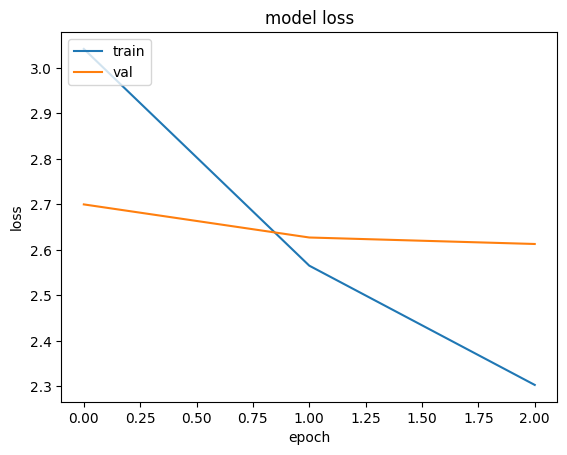

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Sample Generation

In [32]:
input = 'I feel great today. It must be a warm and sunny day'
input_ids = tokenizer.encode(input, return_tensors="tf")
input_ids

<tf.Tensor: shape=(1, 13), dtype=int32, numpy=
array([[   40,  1254,  1049,  1909,    13,   632,  1276,   307,   257,
         5814,   290, 27737,  1110]], dtype=int32)>

In [33]:
output_ids = model.generate(input_ids, max_length=100, num_beams=5, no_repeat_ngram_size=2)
output_ids

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   40,  1254,  1049,  1909,    13,   632,  1276,   307,   257,
         5814,   290, 27737,  1110,   764,   220,   220,  3363,   837,
          340,   318,    13,   464,  4252,   305,  1659,   318, 22751,
          290,   612,   318,   257,  3621,  3608,  3608, 28633,    13,
         1026,   705,   264,   587,   257,   890,   640,  1201,   356,
         1392,   994,    13,  1135,   705,  8016,   587,  2045,  2651,
          284,   340,    13,  5195,   836,   470,   356,   467,   284,
          262, 10481,   290,  2883,   262, 34488,   981,   356,   821,
          287,   262,  4252,  5633,   220,  2061,   338,   262,  2300,
          351,   345,  5633,   921,   804,   523,  9247,   764,  1867,
          338,  2642,   351,   534,  1986,  5633,  1148,   340,  2726,
         5633]], dtype=int32)>

In [34]:
output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
output

"I feel great today. It must be a warm and sunny day.   Yes, it is.The sunroof is shining and there is a nice cool cool breeze.It's been a long time since we got here.We'Ve been looking forward to it.Why don't we go to the beach and enjoy the sunshine while we're in the sun? What's the matter with you? You look so upset. What's wrong with your face? Is it serious?"

The generated texts somewhat makes sense.

## Evaluation

Using test dataset to find perplexity scores

In [36]:
input_ids = tokenized_dataset['test'][0]['input_ids']
input_text = tokenizer.decode(input_ids, skip_special_tokens=True)
input_text

'Hey man, you wanna buy some weed?   Some what?   Weed! You know? Pot, Ganja, Mary Jane some chronic!   Oh, umm, no thanks.   I also have blow if you prefer to do a few lines.   No, I am ok, really.   Come on man! I even got dope and acid! Try some!   Do you really have all of these drugs? Where do you get them from?   I got my connections! Just tell me what you want and I ’ ll even give you one ounce for free.   Sounds good! Let ’ s see, I want.   Yeah?   I want you to put your hands behind your head! You are under arrest! '

In [64]:
input_ids = tokenizer.encode(input_text, return_tensors='tf')
input_ids

<tf.Tensor: shape=(1, 163), dtype=int32, numpy=
array([[10814,   582,    11,   345, 18869,  2822,   617, 20349,    30,
          220,   220,  2773,   644,    30,   220,   220, 43912,     0,
          921,   760,    30,  6902,    11, 23207,  6592,    11,  5335,
        12091,   617, 10726,     0,   220,   220,  3966,    11,   334,
         3020,    11,   645,  5176,    13,   220,   220,   314,   635,
          423,  6611,   611,   345,  4702,   284,   466,   257,  1178,
         3951,    13,   220,   220,  1400,    11,   314,   716, 12876,
           11,  1107,    13,   220,   220,  7911,   319,   582,     0,
          314,   772,  1392, 45654,   290,  7408,     0,  9993,   617,
            0,   220,   220,  2141,   345,  1107,   423,   477,   286,
          777,  5010,    30,  6350,   466,   345,   651,   606,   422,
           30,   220,   220,   314,  1392,   616,  8787,     0,  2329,
         1560,   502,   644,   345,   765,   290,   314,   564,   247,
        32660,   772,  1577, 

In [62]:
output_ids =  model.generate(input_ids, max_length=input_ids.shape[1]+50, num_beams=5, no_repeat_ngram_size=2)
output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
output

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"Hey man, you wanna buy some weed?   Some what?   Weed! You know? Pot, Ganja, Mary Jane some chronic!   Oh, umm, no thanks.   I also have blow if you prefer to do a few lines.   No, I am ok, really.   Come on man! I even got dope and acid! Try some!   Do you really have all of these drugs? Where do you get them from?   I got my connections! Just tell me what you want and I ’ ll even give you one ounce for free.   Sounds good! Let ’ s see, I want.   Yeah?   I want you to put your hands behind your head! You are under arrest! Hi man! What are you talking about? You got arrested for concealing illegal drugs! You can't do something! What's your face mask. You've got a big deal, right? Have you hiding behind you, you. "

In [63]:
logits = model(input_ids).logits
probs = tf.nn.softmax(logits, axis=-1)
target_ids = input_ids[:, 1:]
loss = tf.keras.losses.sparse_categorical_crossentropy(target_ids, logits[:, :-1, :])
perplexity = tf.exp(tf.reduce_mean(loss))

print("Output:", output)
print("Perplexity:", perplexity.numpy())

Output: Hey man, you wanna buy some weed?   Some what?   Weed! You know? Pot, Ganja, Mary Jane some chronic!   Oh, umm, no thanks.   I also have blow if you prefer to do a few lines.   No, I am ok, really.   Come on man! I even got dope and acid! Try some!   Do you really have all of these drugs? Where do you get them from?   I got my connections! Just tell me what you want and I ’ ll even give you one ounce for free.   Sounds good! Let ’ s see, I want.   Yeah?   I want you to put your hands behind your head! You are under arrest! Hi man! What are you talking about? You got arrested for concealing illegal drugs! You can't do something! What's your face mask. You've got a big deal, right? Have you hiding behind you, you. 
Perplexity: 5056.3657


## Evaluation Test Set

Evaluating on 10 test samples and finding preplexity, also calculating mean perplexity

In [106]:
input_ids = tokenized_dataset['test'][:10]['input_ids']

perplexities = []
outputs = []

for input_id in input_ids:
  input_text = tokenizer.decode(input_id, skip_special_tokens=True)
  temp_input_id = tokenizer.encode(input_text, return_tensors='tf')
  output_ids =  model.generate(temp_input_id, max_length=temp_input_id.shape[1]+50, num_beams=5, no_repeat_ngram_size=2)
  output = tokenizer.decode(output_ids[0][-50:], skip_special_tokens=True)
  outputs.append({
      'input' : input_text,
      'output' : output
  })

  #Evaluation
  logits = model(temp_input_id).logits
  probs = tf.nn.softmax(logits, axis=-1)
  target_id = temp_input_id[:, 1:]
  loss = tf.keras.losses.sparse_categorical_crossentropy(target_id, logits[:, :-1, :])
  perplexity = tf.exp(tf.reduce_mean(loss))
  perplexities.append(perplexity.numpy())
  print('done')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


done


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


done


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


done


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


done


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


done


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


done


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


done


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


done


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


done
done


In [108]:
# an output sample
outputs[6]

{'input': "So how did I do on my driving test?   Do you want the truth?   Of course, I do.   Well, you really didn't do all that well.   How bad did I do?   To be completely honest, you failed your test.   How?   There were a number of reasons.   What were they?   Basically, you just can't drive.   Can I have another try?   You can take it in a couple weeks. ",
 'output': "What are you going to do next semester? I ’ d like to make a reservation for a flight to London on October 15th and 19th for October 16th.My parents'saturday morning.Is there anything I can do for"}

In [111]:
perplexities = np.array(perplexities)
np.mean(perplexities)

2805.3667

**The average perplexity of the model is 2805.3667**